In [57]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optimizers
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.utils.data import random_split
import torchvision.transforms as transforms

np.random.seed(123)
torch.manual_seed(123)

In [58]:
class EarlyStopping:
    '''
    早期終了 (early stopping)
    '''
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def __call__(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('early stopping')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False


In [71]:
# データの準備
# データの生成
T = 100
x = np.arange(0, 2*T + 1)
N = x.shape[0]
Sigma = 0.2
mu = np.sin(2.0 * np.pi * x / T)
f = mu + np.random.normal(0, Sigma, N)

# データの分割
maxlen = 25   #最大データ長
x = []
t = []

for i in range(N - maxlen):
    x.append(f[i:i+maxlen])
    t.append(f[i+maxlen])
x = np.array(x).reshape(-1, maxlen, 1)
t = np.array(t).reshape(-1, 1)

# 学習データと検証データに分割
x_train, x_val, t_train, t_val = train_test_split(x, t, test_size=0.2, shuffle=False)

In [72]:
# RNNを定義
class RNN(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.l1 = nn.RNN(1, hidden_dim, nonlinearity="tanh", batch_first=True)
        self.l2 = nn.Linear(hidden_dim, 1)

        nn.init.xavier_normal_(self.l1.weight_ih_l0)
        nn.init.orthogonal_(self.l1.weight_hh_l0)

    def forward(self, x):
        h, _ = self.l1(x)
        y = self.l2(h[:, -1])
        return y

In [73]:
# モデルの学習
# アルゴリズムの定義
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNN(50).to(device)
criterion = nn.MSELoss(reduction="mean")

# optimizerを定義
optimizer = optimizers.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), amsgrad=True)

def compute_loss(t, y):
    return criterion(y, t)

def train_step(x, t):
    x = torch.Tensor(x).to(device)
    t = torch.Tensor(t).to(device)
    model.train()
    preds = model(x)
    loss = compute_loss(t, preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss, preds

def val_step(x, t):
    x = torch.Tensor(x).to(device)
    t = torch.Tensor(t).to(device)
    model.eval()
    preds = model(x)
    loss = criterion(preds, t)
    return loss, preds

# アルゴリズムの設定
epochs = 1000
batch_size = 100
n_batches_train = x_train.shape[0] // batch_size + 1
n_batches_val = x_val.shape[0] // batch_size + 1
hist = {"train_loss": [], "val_loss" : []}
es = EarlyStopping(patience=10, verbose=1)
disp = 10

In [74]:
# RNNパラメータを推定
for epoch in range(epochs):
    
    train_loss = 0.0
    val_loss = 0.0
    x_, t_ = shuffle(x_train, t_train)

    for batch in range(n_batches_train):
        start = batch * batch_size
        end = start + batch_size
        loss, _ = train_step(x_[start:end], t_[start:end])
        train_loss += loss.item()

    for batch in range(n_batches_val):
        start = batch * batch_size
        end = start + batch_size
        loss, _ = val_step(x_val[start:end], t_val[start:end])
        val_loss += loss.item()

    train_loss /= n_batches_train
    val_loss /= n_batches_val

    hist["train_loss"].append(train_loss)
    hist["val_loss"].append(val_loss)

    if epoch%disp==0:
        print("epoch: {}, loss: {:.3}, val_loss: {:.3}".format(epoch, train_loss, val_loss))
        
    if es(val_loss):
        break

epoch: 0, loss: 0.613, val_loss: 0.677
epoch: 10, loss: 0.069, val_loss: 0.0812
epoch: 20, loss: 0.0598, val_loss: 0.0712
epoch: 30, loss: 0.0558, val_loss: 0.0575
epoch: 40, loss: 0.0495, val_loss: 0.0443
epoch: 50, loss: 0.0458, val_loss: 0.0412
epoch: 60, loss: 0.0503, val_loss: 0.0376
early stopping


In [75]:
# モデルの評価
model.eval()
gen = [0 for i in range(maxlen)]
z = x[:1]

for i in range(N - maxlen):
    z_ = torch.Tensor(z[-1:]).to(device)
    preds = model(z_).data.cpu().numpy()
    z = np.append(z, preds)[1:]
    z = z.reshape(-1, maxlen, 1)
    gen.append(preds[0, 0])

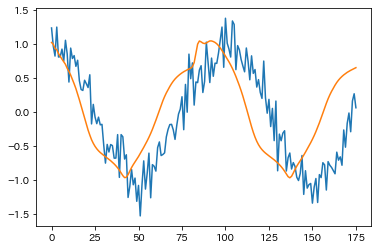

In [76]:
# 予測結果を可視化
plt.plot(f[maxlen:])
plt.plot(np.array(gen)[maxlen:])